In [24]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

In [20]:
train_dir = r'E:\Yoga_pose\DATASET\TRAIN' #directory with training images
test_dir = r'E:\Yoga_pose\DATASET\TEST' #directory with testing images

In [21]:
train_datagen = ImageDataGenerator(width_shift_range= 0.1,
                                  horizontal_flip = True,
                                  rescale = 1./255,
                                  validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale = 1./255,
                                 validation_split = 0.2)

In [22]:
train_generator =  train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (75,75),
                                                    color_mode = 'rgb',
                                                    class_mode = 'categorical',
                                                    batch_size = 16,
                                                    subset = 'training')
validation_generator  = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = (75,75),
                                                  color_mode = 'rgb',
                                                  class_mode = 'categorical',
                                                  subset = 'validation')

Found 866 images belonging to 5 classes.
Found 92 images belonging to 5 classes.


In [ ]:
model = tf.keras.models.Sequential([
     # --- Tầng 1 ---
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='Same', input_shape=(75, 75, 3)),  # Lọc đặc trưng cơ bản
    tf.keras.layers.MaxPooling2D(2, 2),  # Giảm kích thước ảnh
    tf.keras.layers.Dropout(0.25),       # Giảm overfitting
    #tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding = 'Same'),
    #tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.Dropout(0.25),
    #tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding = 'Same'),
    #tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.Dropout(0.25),
    # --- Tầng 2 ---
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='Same'),  # Học đặc trưng phức tạp hơn
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    # --- Tầng 3 ---
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='Same'),  # Học đặc trưng sâu
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    # --- Fully Connected ---
    tf.keras.layers.Flatten(),                            # Chuyển sang vector 1D
    tf.keras.layers.Dense(1024, activation='relu'),        # Học mối quan hệ phi tuyến
    tf.keras.layers.Dropout(0.5),                         # Chống overfitting
    tf.keras.layers.Dense(5, activation='softmax')         # Dự đoán 5 lớp (xác suất)
])

c:\Users\minhh\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy'])
epochs = 50  
batch_size = 16

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 75, 75, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    21,234,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,610,629 (82.44 MB)

 Trainable params: 21,610,629 (82.44 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [17]:
# from tensorflow.keras.callbacks import ModelCheckpoint
# path = "../model2/weights-{epoch:02d}.hdf5"
# checkpoint = ModelCheckpoint(path, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq=1)
# callback = [checkpoint]

In [18]:
# history = model.fit(train_generator, epochs = epochs,validation_data = validation_generator,callbacks = callback)
history = model.fit(train_generator, epochs = epochs,validation_data = validation_generator)

c:\Users\minhh\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
11/55 ━━━━━━━━━━━━━━━━━━━━ 28s 637ms/step - accuracy: 0.2561 - loss: 3.5179

c:\Users\minhh\anaconda3\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


55/55 ━━━━━━━━━━━━━━━━━━━━ 46s 817ms/step - accuracy: 0.2182 - loss: 1.8165 - val_accuracy: 0.2391 - val_loss: 1.5951
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 67s 536ms/step - accuracy: 0.2379 - loss: 1.5998 - val_accuracy: 0.2500 - val_loss: 1.5998
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 285ms/step - accuracy: 0.2506 - loss: 1.5911 - val_accuracy: 0.5217 - val_loss: 1.5419
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 34s 625ms/step - accuracy: 0.3776 - loss: 1.4984 - val_accuracy: 0.4348 - val_loss: 1.2879
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 280ms/step - accuracy: 0.4492 - loss: 1.3758 - val_accuracy: 0.5652 - val_loss: 1.1243
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 278ms/step - accuracy: 0.4769 - loss: 1.2925 - val_accuracy: 0.7283 - val_loss: 0.7439
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 275ms/step - accuracy: 0.5670 - loss: 1.1648 - val_accuracy: 0.7935 - val_loss: 0.7627
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 27s 486ms/step - accuracy: 0.5797 - loss: 1.0718 - val_accuracy: 0.760

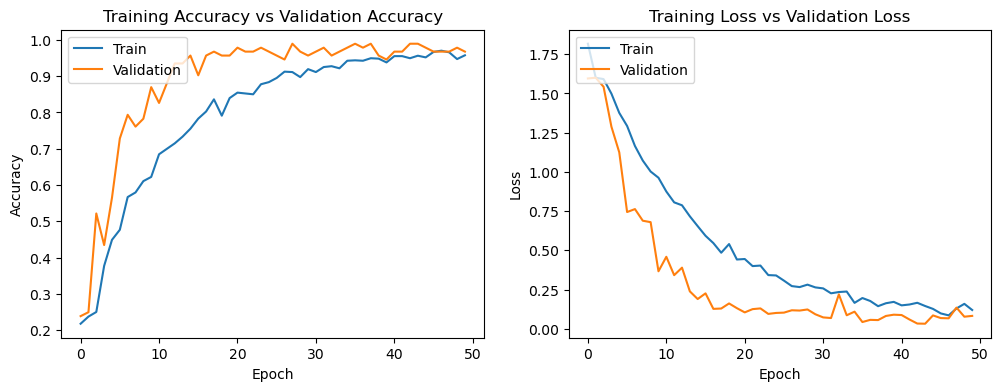

In [19]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()